# Importing Module and define directories

In [66]:
%matplotlib inline
project_dir = '../../'
data_dir = project_dir + 'data/'

import sys
sys.path.append(project_dir + 'NN/')

import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
import MLP
import layer
importlib.reload(MLP)
importlib.reload(layer)
from MLP import MLP
from utils.preprocessing import split,StandardScaler, MinMaxScaler
from utils.results import plot_results, output_correlations
from utils.regressor import regressor
from utils.trick_output import lin_sin_lin, trick_params
import ensemble
importlib.reload(ensemble)
from ensemble import bagging_ensemble

# Train - Validation Split

In [67]:
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]
data = raw_data[:,:10] ; labels = raw_data[:,-2:]
norm_data = MinMaxScaler()
norm_labels = MinMaxScaler()
data = norm_data.fit_transform(data)
labels = norm_labels.fit_transform(labels)
all_norm_data = np.column_stack((data, labels))

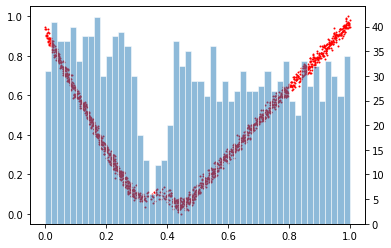

In [68]:
hard_out = labels[:, 1]
easy_out = labels[:, 0]

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.scatter(hard_out, easy_out, s = 1, c='red')
ax_right.hist(hard_out, bins = 50, alpha = 0.5, ec="white")
plt.show()

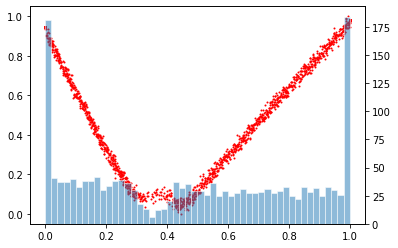

In [69]:
def generate_in_middle(dataset, d1, d2):
    mid = (dataset[d1, :] + dataset[d2, :])/2
    return np.row_stack((dataset, mid))

def expand_in_middle(n_new_data, dataset, lim_inf, lim_sup, unbal_feature):
    data_copy = np.copy(dataset)
    mask_inf = data_copy[:, unbal_feature] > lim_inf
    mask_sup = data_copy[:, unbal_feature] < lim_sup
    mid_data = data_copy[np.logical_and(mask_inf, mask_sup)]
    rng = np.random.default_rng()
    for i in range(n_new_data):
        val = rng.normal(loc = (lim_inf + lim_sup)/2, 
                         scale = np.abs((lim_inf - lim_sup)/2))
        sort_for_val = np.argsort(np.abs(data_copy[:,unbal_feature]-val))
        d1 = sort_for_val[0]
        d2 = sort_for_val[1]
        data_copy = generate_in_middle(data_copy, d1, d2)
    return data_copy

new_dataset = expand_in_middle(150, all_norm_data, 1.3, 1.7, 11)
new_dataset = expand_in_middle(150, new_dataset, -1.6, -1.4, 11)

hard_out = new_dataset[:, 11]
easy_out = new_dataset[:, 10]

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.scatter(hard_out, easy_out, s = 1, c='red')
ax_right.hist(hard_out, bins = 50, alpha = 0.5, ec="white")
plt.show()

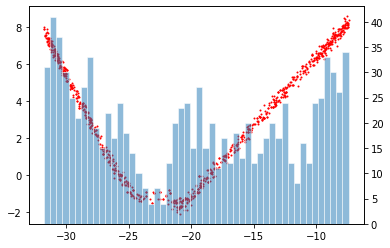

In [70]:
def generate_in_middle(dataset, d1, d2):
    mid = (dataset[d1, :] + dataset[d2, :])/2
    return np.row_stack((dataset, mid))

def remove_in_middle(n, dataset, lim_inf, lim_sup, unbal_feature):
    data_copy = np.copy(dataset)
    mask_inf = data_copy[:, unbal_feature] > lim_inf
    mask_sup = data_copy[:, unbal_feature] < lim_sup
    left_data = data_copy[data_copy[:, unbal_feature] < lim_inf]
    mid_data = data_copy[np.logical_and(mask_inf, mask_sup)]
    right_data = data_copy[data_copy[:, unbal_feature] > lim_sup]
    rng = np.random.default_rng()
    mid_data = rng.choice(mid_data, size = len(mid_data) - n )
    data_copy = np.row_stack((left_data, mid_data))
    data_copy = np.row_stack((data_copy, right_data))
    return data_copy

new_dataset = remove_in_middle(500, raw_data, -30, -10, 11)

hard_out = new_dataset[:, 11]
easy_out = new_dataset[:, 10]

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.scatter(hard_out, easy_out, s = 1, c='red')
ax_right.hist(hard_out, bins = 50, alpha = 0.5, ec="white")
plt.show()

In [71]:
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]
data = raw_data[:,:10] ; labels = raw_data[:,-2:]
norm_data = StandardScaler()
norm_labels = StandardScaler()
data = norm_data.fit_transform(data)
labels = norm_labels.fit_transform(labels)

frac_test=0.1
data, test_set, labels, test_labels = split(data, labels, 
                                            kind="hold_out",frac_training=1-frac_test)

In [72]:
#xavier weight inizialization
def xavier(structure):
    start=np.zeros(len(structure))
    for idx,num in enumerate(structure):
        if idx==0:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx])
        else:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx-1]+structure[idx])
    return list(start)


# Define the MLP

## Train the model

In [73]:
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]
data = raw_data[:,:10] ; labels = raw_data[:,-2:]
norm_data = StandardScaler()
norm_labels = StandardScaler()
data = norm_data.fit_transform(data)
labels = norm_labels.fit_transform(labels)

frac_test=0.1
data, test_set, labels, test_labels = split(data, labels, 
                                            kind="hold_out",frac_training=1-frac_test)

frac_training=0.8
input_data, val_data, train_labels, val_labels=split(data, labels,kind="hold_out",
                                                     frac_training=frac_training)


train_labels1 = train_labels[:,1].reshape((len(train_labels),1))
val_labels1 = val_labels[:,1].reshape((len(val_labels), 1))

In [74]:
other_output= train_labels[:,0]
lin_output= train_labels[:,1]

x = np.copy(lin_output)
y = np.copy(other_output)

used_data = np.column_stack((input_data, train_labels))

xx = np.linspace(np.min(x), np.max(x), 1000)
params = trick_params(norm_name = 'std')

reg = regressor()
reg.fit(x, y, lin_sin_lin, params)
popt_sin = reg.best_params

# fig, axs = plt.subplots(1, 2, figsize = (10, 3))
# axs[0].plot(xx,lin_sin_lin(xx,*popt_sin))
# axs[0].scatter(x, y, s = 5, label ='real', alpha = 0.3, c='orange')
# axs[0].set_title('fit func vs data')
# axs[1].scatter(x, y-lin_sin_lin(x,*popt_sin), s = 5)
# axs[1].set_title('residual')
# plt.show()
# RMS = np.sqrt(np.sum((y-lin_sin_lin(x,*popt_sin))**2))
# print(f'RMS = {RMS} (root sum of squared residual)')

reg.reason

'kmax iteration reached'

In [75]:
structure=[10,5, 2]
act_func=[("tanh",1)]*(len(structure)-1) + [("linear",1)]
start=xavier(structure)

N_epoch = 50000
lamb=1e-6; batch_size = -1; alpha=0.1 ; nesterov=True ; eta_function=5e-3
beta=0.5
netw = MLP(structure, func=act_func,starting_points=start)

In [76]:
netw.train(input_data, train_labels , val_data, val_labels,
           epoch = N_epoch,
           batch_size=batch_size,
           eta = eta_function, lamb = lamb,alpha=alpha,
           nesterov=nesterov,RMSProp=True,beta=beta,
           patience = 100, error_threshold = 0.)

Epoch 198:  [train MEE = 0.2767]  [val MEE = 0.2754]                              
Elapsed time: 1.7019307613372803 s


# Plot results

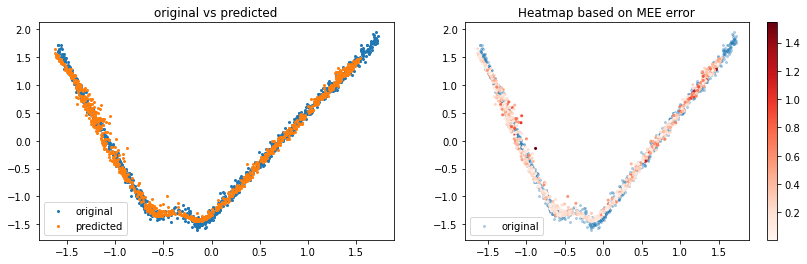

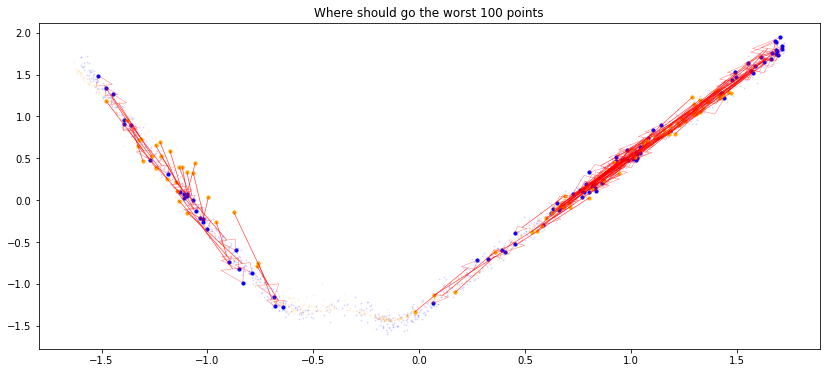

In [77]:
import utils.results
importlib.reload(utils.results)
from utils.results import plot_results, output_correlations

w = output_correlations(netw, input_data, train_labels, plot_arrow_worse = 100,
                    fit_func = lin_sin_lin, func_args = popt_sin
                   )

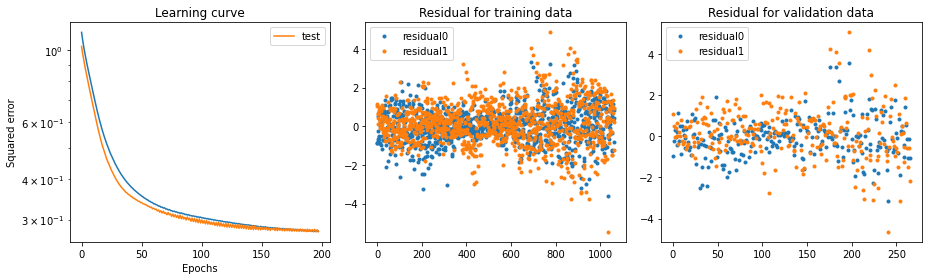

final train error: 1.1358316301641762
final val error: 1.188929644759298


In [78]:
plot_results(netw, input_data, val_data, train_labels, val_labels, 
             func = lin_sin_lin, func_args = popt_sin, mean_fit = True,
             norm = norm_labels.inverse_transform,
             sortidx = 1)

## Try an ensemble

In [79]:
import ensemble
importlib.reload(ensemble)
from ensemble import bagging_ensemble

In [80]:
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]
data = raw_data[:,:10] ; labels = raw_data[:,-2:]
norm_data = StandardScaler()
norm_labels = StandardScaler()
data = norm_data.fit_transform(data)
labels = norm_labels.fit_transform(labels)


frac_test=0.1
data, test_set, labels, test_labels = split(data, labels, 
                                            kind="hold_out",frac_training=1-frac_test)

frac_training=0.8
dict_split = {'kind':'hold_out', 'frac_training':frac_training}

#xavier weight inizialization
def xavier(structure):
    start=np.zeros(len(structure))
    for idx,num in enumerate(structure):
        if idx==0:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx])
        else:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx-1]+structure[idx])
    return list(start)

structure=[50,50, labels.shape[-1]]
act_func=["tanh"]*(len(structure)-1) + ["linear"]
start=xavier(structure)

dict_MLP = {'structure':structure, 'func':act_func, 'starting_points':xavier(structure)}

N_epoch = 10000
lamb=0.#1e-4
batch_size = 50 #-1 for batch gradient descent
alpha=0.3
nesterov=True
eta=1e-4
beta=0.7
dict_train = {'epoch':N_epoch, 'batch_size':batch_size, 'eta':eta, 'lamb':lamb, 
              'alpha':alpha, 'nesterov':nesterov, 'RMSProp':True, 'beta':beta,
              'error_threshold':0., 'patience':50, 'verbose':True}

bagg = bagging_ensemble(5)
bagg.train(data, labels, MLP, dict_MLP, dict_train, split, dict_split)

act_func=["tanh"]*(len(structure)-1) + ["linear"]
dict_MLP_tanh = {'structure':structure, 'func':act_func, 'starting_points':xavier(structure)}
#bagg.train(data, labels, MLP, dict_MLP_tanh, dict_train, split, dict_split)

0/5
Epoch 694:  [train MEE = 0.1811]  [val MEE = 0.1796]                              
Elapsed time: 108.52931594848633 s
1/5
Epoch 1150:  [train MEE = 0.1471]  [val MEE = 0.1617]                              
Elapsed time: 174.80649161338806 s
2/5
Epoch 511:  [train MEE = 0.1974]  [val MEE = 0.2029]                              
Elapsed time: 76.70635223388672 s
3/5
Epoch 677:  [train MEE = 0.1897]  [val MEE = 0.2041]                              
Elapsed time: 99.75209522247314 s
4/5
Epoch 869:  [train MEE = 0.1445]  [val MEE = 0.1621]                              
Elapsed time: 129.54658555984497 s


In [81]:
bagg.prune_ensemble

Pruned 0/5 classifier


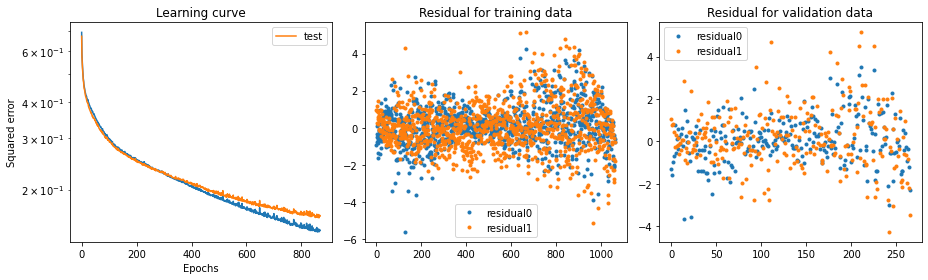

final train error: 1.3070859799310974
final val error: 1.3592467297593953


In [91]:
frac_training=0.8
input_data, val_data, train_labels, val_labels=split(data, labels,kind="hold_out",
                                               frac_training=frac_training)

plot_results(bagg.list_classifier[4], input_data, val_data, train_labels, val_labels,func = lin_sin_lin, func_args = popt_sin,
             mean_fit = True, norm = norm_labels.inverse_transform, 
             sortidx = 1)



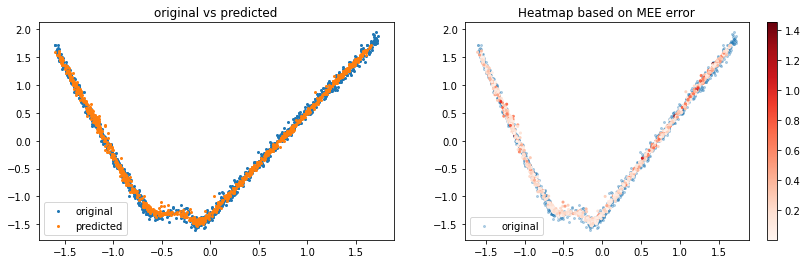

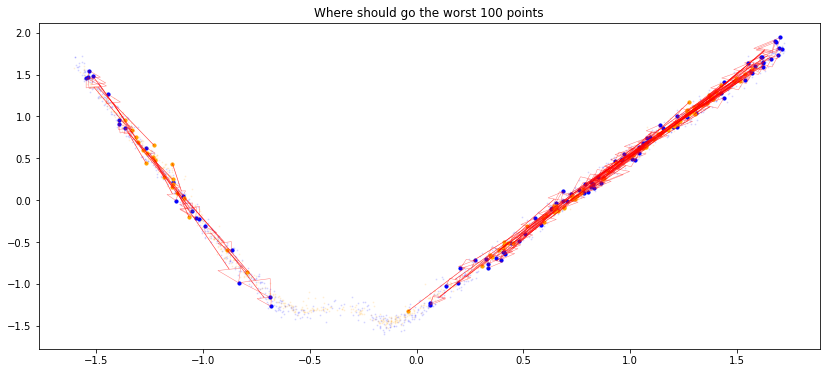

[ 509  237  636   42  725  772  449  110  270  481  519  172  697 1049
   24  819  831  537  617  992  461  168  272  227  615  202  217  260
  727  630  982   65  570  666  870  671  146  900   17  363  789  629
  275  462  960  550 1015  594  833  918  867  126 1058  394  395  850
 1023  430 1055  485  841  676  968  435 1008  176  885  147 1027  554
  521  588  401  996 1002  160  233 1019  347  465  684  389  533  476
  596  357  440 1057   91 1050  478   39  957  866   52  452  663  642
   49  474]


In [83]:
w_worst = output_correlations(bagg, input_data, train_labels, plot_arrow_worse = 100,
                    fit_func = lin_sin_lin, func_args = popt_sin
                   )

print(w_worst)

In [84]:
structure=[10,5, 2]
act_func=[("tanh",1)]*(len(structure)-1) + [("linear",1)]
start=xavier(structure)

N_epoch = 500
lamb=1e-6; batch_size = -1; alpha=0.1 ; nesterov=True ; eta_function=5e-3
beta=0.5
worst_nt = MLP(structure, func=act_func,starting_points=start)

In [85]:
worst_nt.train(input_data[w_worst], train_labels[w_worst] , val_data, val_labels,
           epoch = N_epoch,
           batch_size=batch_size,
           eta = eta_function, lamb = lamb,alpha=alpha,
           nesterov=nesterov,RMSProp=True,beta=beta,
           patience = -1, error_threshold = 0 )

Epoch 500:  [train MEE = 0.4213]  [val MEE = 0.7547]                              
Elapsed time: 1.08659029006958 s


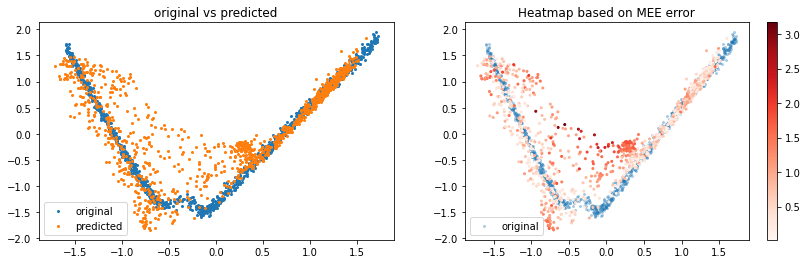

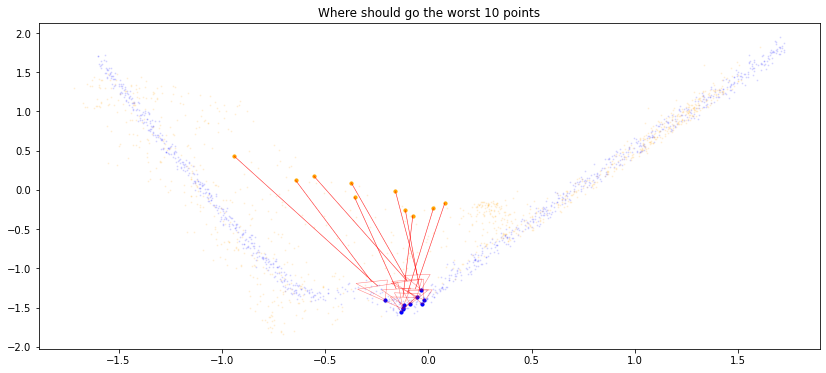

array([ 768,  484,  695,  791, 1044, 1061,  507,  157,  584,  529])

In [86]:
output_correlations(worst_nt, input_data, train_labels, plot_arrow_worse = 10,
                    fit_func = lin_sin_lin, func_args = popt_sin
                   )
